# Affect of climate change in different regions around the 🌎

---



Using this tool, you can evaluate long term trends of climate change by automatically extracting more than 60 years of historical (1958-2020) and 30 years of projected (4 degree Celsius warming, 1985-2015) precipitation records for any location in the world.

Please uncomment the following line before using the tool for another exercise (i.e., when you intend to try the tool for a new location). This action will delete the entire output folder of your previous exercise. 

In [ ]:
 !rm -rf '/content/project'

## Step 1: Install modules 📊

In [ ]:
!pip install folium wget netCDF4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Step 2: Import modules 📊

In [ ]:
import folium, wget, os, csv, os.path, datetime
from folium import plugins
from branca.element import Figure
import netCDF4 as nc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import linregress
from google.colab import files
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.dates import DateFormatter
import xarray as xr
from google.colab import files
%matplotlib inline

## Step 3: Download precipitation data ⛈️


The tool can automatically access two precipition datasets from any location in the world from a dataset called **TerraClimate**: (i) more than 60 years of precipitation record from 1958 to 2020**,  and (ii) a projected precipitation with respect to a climatological baseline of 1985-2015, considering climate changes (+4 degree Celsius warming). See the following references for more details. 

Reference: 
1. Abatzoglou, J., Dobrowski, S., Parks, S. et al. TerraClimate, a high-resolution global dataset of monthly climate and climatic water balance from 1958–2015. Sci Data 5, 170191 (2018). https://doi.org/10.1038/sdata.2017.191 **[Historical record]**

2. Qin, Y., Abatzoglou, J.T., Siebert, S. et al. Agricultural risks from changing snowmelt. Nat. Clim. Chang. 10, 459–465 (2020). https://doi.org/10.1038/s41558-020-0746-8 **[Projected (+4C warming) record]**

**TerraClimate gets frequently updated to include recent data. 

This tool can automatically access the new data whenever it is available in TerraClimate. 

In [ ]:
out_dir = '/content/project'
if not os.path.exists(out_dir + '/Prep'):
  os.makedirs(out_dir + '/Prep')

print("Please select your time range")
Start_year = str(input("Enter the start year for historical precipitation data (1985-2020): "))
End_year = str(input("Enter the end year for historical precipitation data (1985-2020): "))
Start_year2 = str(input("Enter the start year for climate change data (1985-2015): "))
End_year2 = str(input("Enter the end year for climate change data (1985-2015): "))

base_P_url = "http://thredds.northwestknowledge.net:8080/thredds/fileServer/TERRACLIMATE_ALL/data/TerraClimate_ppt_"
for i in range(int(Start_year), int(End_year)+1):
  target_P_url = base_P_url +str(i)+'.nc'
  file_P = '/content/project/Prep/TerraClimate_ppt_'+str(i)+'.nc'
  if os.path.exists(file_P):
    pass
  else: 
    wget.download(target_P_url, out=out_dir + '/Prep')


base_F_url = "http://thredds.northwestknowledge.net:8080/thredds/fileServer/TERRACLIMATE_ALL/data_plus4C/TerraClimate_4c_ppt_"
for j in range(int(Start_year2), int(End_year2)+1):
  target_P_url = base_P_url +str(j)+'.nc'
  target_F_url = base_F_url +str(j)+'.nc'
  file_P = '/content/project/Prep/TerraClimate_ppt_'+str(j)+'.nc'
  file_F = '/content/project/Prep/TerraClimate_4c_ppt_'+str(j)+'.nc'
  
  if os.path.exists(file_P):
    pass
  else:
    wget.download(target_P_url, out=out_dir + '/Prep')
  if os.path.exists(file_F):
    pass
  else: 
    wget.download(target_F_url, out=out_dir + '/Prep')
    
print("Job done")


Please select your time range
Enter the start year for historical precipitation data (1985-2020): 1985
Enter the end year for historical precipitation data (1985-2020): 2021
Enter the start year for climate change data (1985-2015): 1985
Enter the end year for climate change data (1985-2015): 1990
Job done


## Step 4: Browse over an interactive global map and select your location of interest 🗺️


Browse over the map, zoom-in to your location of interest, and left-click the mouse. The map will show the latitude and longtitude of your location.

In [ ]:
m = folium.Map(min_zoom=2, max_bounds=True, tiles = 'Stamen Terrain')
m.add_child(folium.LatLngPopup())
m.add_child(folium.LayerControl())
m

Note the latitude and longitude shown on the map and type them in the fields below.

In [ ]:
Lat = str(input("Please type latitude: "))
Lon = str(input("Please type longitude: "))

Please type latitude: 29.9930
Please type longitude: 70.3125


## Step 5: Post-processing netCDF files 🔮🌟📈


Read netCDF file and check the units of the datasets 

In [ ]:
os.chdir("/content/project/Prep")

p = xr.open_mfdataset("TerraClimate_ppt_*.nc")
f = xr.open_mfdataset("TerraClimate_4c_ppt_*.nc")

f

<xarray.Dataset>
Dimensions:  (lat: 4320, lon: 8640, time: 72, crs: 1)
Coordinates:
  * lat      (lat) float64 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
  * time     (time) datetime64[ns] 1985-01-01 1985-02-01 ... 1990-12-01
  * crs      (crs) int16 3
Data variables:
    ppt      (time, lat, lon) float32 dask.array<chunksize=(12, 4320, 8640), meta=np.ndarray>

### (i) Read and extract monthly precipitation data from netCDF, then save it as a CSV file 💾 

In [ ]:
results_path = out_dir + '/results'
if not os.path.exists(results_path):
  os.makedirs(results_path)

p1 = p.sel(lon=Lon,lat=Lat,method='nearest')['ppt'].to_dataframe()
p1 = p1.rename(columns ={'ppt':'Past_Precp_(mm/month)'})
p2 = p1.rename_axis("Month")
p2 = p2[Start_year:End_year]
p2 = p2["Past_Precp_(mm/month)"]
p2.index= pd.to_datetime(p2.index, format = '%m/%Y').strftime('%Y-%m')
print(p2.head())
p2.to_csv(results_path+'/Historical_Monthly_Prep_%s_%s.csv' % (Start_year, End_year))


f1 = f.sel(lon=Lon,lat=Lat,method='nearest')['ppt'].to_dataframe()
f1 = f1.rename(columns = {'ppt':'Projected(+4C_warming)_Precp_(mm/month)'})

result = pd.merge(p1, f1, on=["time"])
result.reset_index(inplace=True)
result['time']= result['time'].dt.to_period('M')
result = result.rename(columns = {'time':'Month'})
result = result[["Month","Past_Precp_(mm/month)","Projected(+4C_warming)_Precp_(mm/month)"]]
print(result.head())
result.to_csv(results_path+'/ClimateChange_Monthly_Prep_%s_%s.csv' % (Start_year2, End_year2), index = False)

### (ii) Calculate yearly total precipitation data, then save it as a CSV file 📁

In [ ]:
monthly_p = pd.read_csv(results_path+'/Historical_Monthly_Prep_%s_%s.csv' % (Start_year, End_year))
monthly_p = monthly_p.rename(columns = {'Month':'Year','Past_Precp_(mm/month)':'Past_Precp_(mm/yr)'})
monthly_p.Year = pd.to_datetime(monthly_p.Year)
yearly_p = monthly_p.resample('Y',on='Year').sum()
yearly_p.reset_index(inplace=True)
yearly_p['Year']= yearly_p['Year'].dt.to_period('Y')
print(yearly_p.head())
yearly_p.to_csv(results_path+'/Historical_Yearly_Prep_%s_%s.csv' % (Start_year, End_year), index = False)

monthly_cc = pd.read_csv(results_path+'/ClimateChange_Monthly_Prep_%s_%s.csv' % (Start_year2, End_year2))
monthly_cc = monthly_cc.rename(columns = {'Month':'Year','Past_Precp_(mm/month)':'Past_Precp_(mm/yr)','Projected(+4C_warming)_Precp_(mm/month)':'Projected(+4C_warming)_Precp_(mm/yr)'})
monthly_cc.Year = pd.to_datetime(monthly_cc.Year)
yearly_cc = monthly_cc.resample('Y',on='Year').sum()
yearly_cc.reset_index(inplace=True)
yearly_cc['Year']= yearly_cc['Year'].dt.to_period('Y')
print(yearly_cc.head())
yearly_cc.to_csv(results_path+'/ClimateChange_Yearly_Prep_%s_%s.csv' % (Start_year2, End_year2), index = False)

NameError: ignored

## Step 6: Visualize how precipitation has been changing over the years in your location of interest

### (i) Time-serie plot for historical precipitation over the year in location of interest 📊📊📊

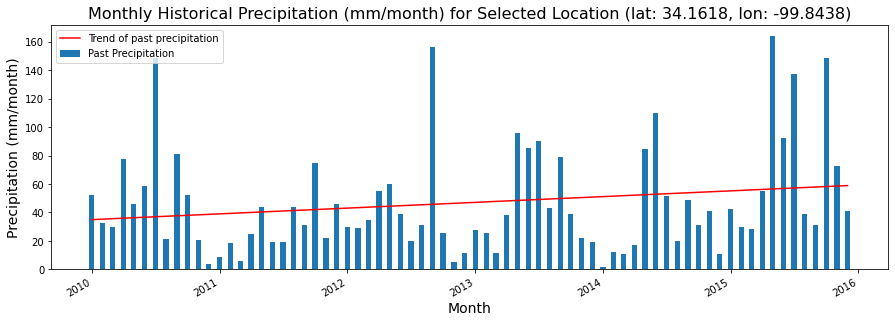

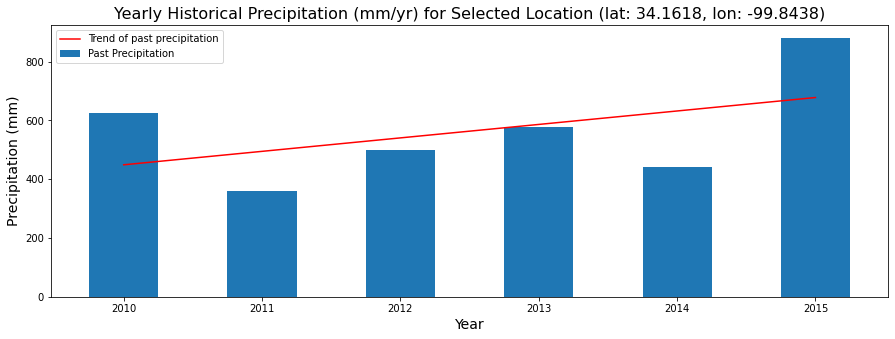

In [ ]:
monthly_data = pd.read_csv(results_path+'/Historical_Monthly_Prep_'+Start_year+'_'+End_year+'.csv')
monthly_data.insert(0, 'ID', np.arange(len(monthly_data)) + 1)
monthly_data.Month = pd.to_datetime(monthly_data.Month)
x1_m=monthly_data.ID
y1_m=monthly_data['Past_Precp_(mm/month)']
xdate1_m = [x.date() for x in monthly_data.Month]
slope1, intercept1, r_value1, p_value1, std_err1 = linregress(x1_m, y1_m)
  
plot_monthly=plt.figure(figsize=(15, 5))
bar1 = plt.bar(xdate1_m, y1_m, 15, label='Past Precipitation')
line1 = plt.plot(xdate1_m, intercept1 + slope1*x1_m, 'r', label='Trend of past precipitation')
plt.gcf().autofmt_xdate()
plt.xlabel('Month', fontsize = 14)
plt.ylabel('Precipitation (mm/month)', fontsize = 14)
plt.title('Monthly Historical Precipitation (mm/month) for Selected Location (lat: %s, lon: %s)'%(Lat, Lon), fontsize = 16)
plt.legend()
plot_monthly.show()


yearly_data = pd.read_csv(results_path+'/Historical_Yearly_Prep_'+Start_year+'_'+End_year+'.csv')
yearly_data.insert(0, 'ID', np.arange(len(yearly_data)) + 1)
x1_y=yearly_data.ID
y1_y=yearly_data['Past_Precp_(mm/yr)']
xdate1_y = yearly_data.Year
slope3, intercept3, r_value3, p_value3, std_err3 = linregress(x1_y, y1_y)
  
plot_yearly=plt.figure(figsize=(15, 5))
bar1 = plt.bar(xdate1_y, y1_y, 0.5, label='Past Precipitation')
line1 = plt.plot(xdate1_y, intercept3 + slope3*x1_y, 'r', label='Trend of past precipitation')
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Precipitation (mm)', fontsize = 14)
plt.title('Yearly Historical Precipitation (mm/yr) for Selected Location (lat: %s, lon: %s)'%(Lat, Lon), fontsize = 16)
plt.legend()
plot_yearly.show()

### (ii) Comparison of historical and projected (+4C warming) preciptiation over the years in location of interest 🗺️📍

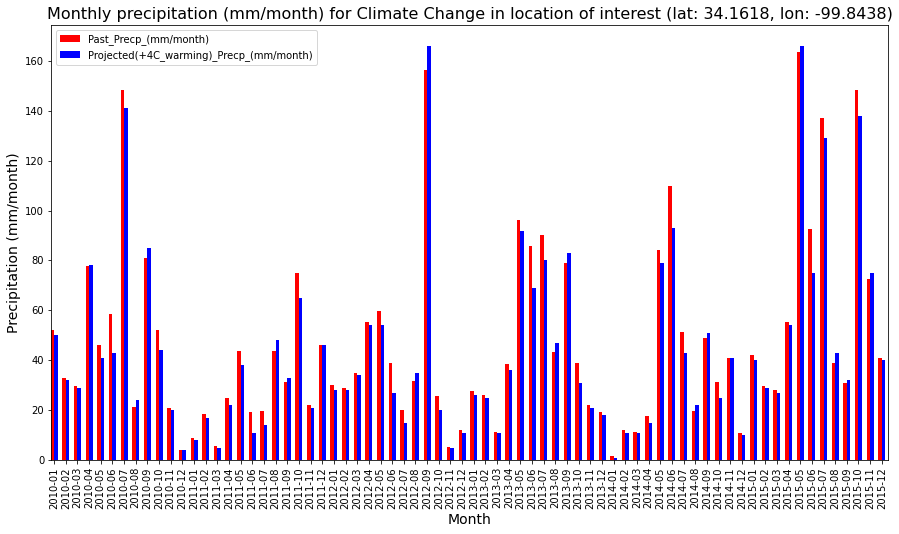

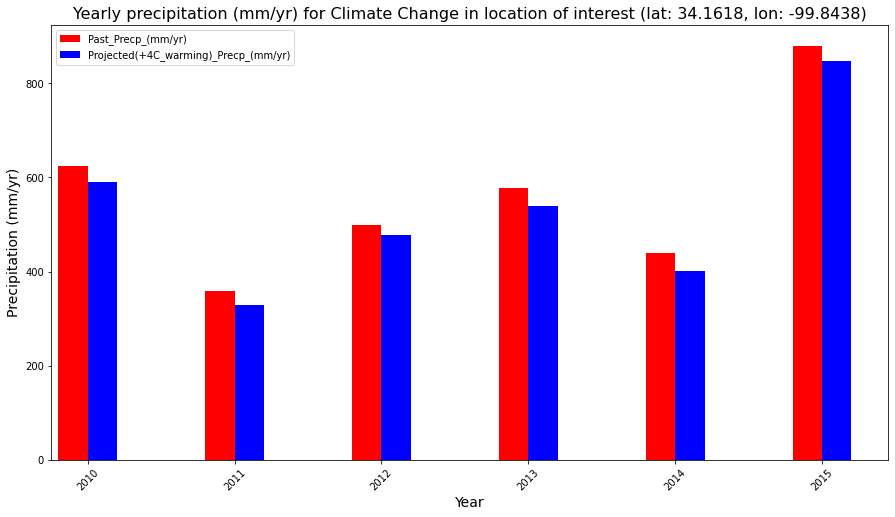

In [ ]:
from matplotlib import ticker

comparem_data = pd.read_csv(results_path+'/ClimateChange_Monthly_Prep_'+Start_year2+'_'+End_year2+'.csv')
f2 = comparem_data.set_index('Month')

plot_comparem = plt.figure(figsize=(15, 8)) 
ax_m = plot_comparem.add_subplot() 
width = 0.3
f2['Past_Precp_(mm/month)'].plot(kind='bar', color='red', ax=ax_m, width=width, position=1)
f2['Projected(+4C_warming)_Precp_(mm/month)'].plot(kind='bar', color='blue', ax=ax_m, width=width, position=0)

plt.xlabel('Month', fontsize = 14)
plt.ylabel('Precipitation (mm/month)', fontsize = 14)
plt.title('Monthly precipitation (mm/month) for Climate Change in location of interest (lat: %s, lon: %s)'%(Lat, Lon), fontsize = 16)
plt.legend()
plot_comparem.show()


comparey_data = pd.read_csv(results_path+'/ClimateChange_Yearly_Prep_'+Start_year2+'_'+End_year2+'.csv')
comparey_data['Year']=comparey_data['Year'].astype(str)
f3 = comparey_data.set_index('Year')

plot_comparey = plt.figure(figsize=(15, 8)) 
ax_y = plot_comparey.add_subplot() 
width = 0.2
f3['Past_Precp_(mm/yr)'].plot(kind='bar', color='red', ax=ax_y, width=width, position=1)
f3['Projected(+4C_warming)_Precp_(mm/yr)'].plot(kind='bar', color='blue', ax=ax_y, width=width, position=0)
ax_y.tick_params(axis='x', labelrotation=45)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Precipitation (mm/yr)', fontsize = 14)
plt.title('Yearly precipitation (mm/yr) for Climate Change in location of interest (lat: %s, lon: %s)'%(Lat, Lon), fontsize = 16)
plt.legend()
plot_comparey.show()

## Step 7: Performing statistical analysis of climate change 🖩


In [ ]:
monthly_data = pd.read_csv(results_path+'/ClimateChange_Monthly_Prep_'+Start_year2+'_'+End_year2+'.csv')
def esc(code):
    return f'\033[{code}m'
print(esc('31;1;4') + 'Summary statistics of monthly precipitation'+ esc(0))
print(monthly_data.agg(
    {"Past_Precp_(mm/month)":["count","mean","std","min","max"],
     "Projected(+4C_warming)_Precp_(mm/month)":["count","mean","std","min","max"]
     }))


yearly_data = pd.read_csv(results_path+'/ClimateChange_Yearly_Prep_'+Start_year2+'_'+End_year2+'.csv')
def esc(code):
    return f'\033[{code}m'
print(esc('31;1;4') + 'Summary statistics of yearly precipitation'+ esc(0))
print(yearly_data.agg(
    {"Past_Precp_(mm/yr)":["count","mean","std","min","max"],
     "Projected(+4C_warming)_Precp_(mm/yr)":["count","mean","std","min","max"]
     }))

Summary statistics of monthly precipitation
       Past_Precp_(mm/month)  Projected(+4C_warming)_Precp_(mm/month)
count              72.000000                                72.000000
mean               46.934722                                44.236111
std                37.666263                                36.708019
min                 1.600000                                 1.000000
max               163.700000                               166.000000
Summary statistics of yearly precipitation
       Past_Precp_(mm/yr)  Projected(+4C_warming)_Precp_(mm/yr)
count            6.000000                              6.000000
mean           563.216667                            530.833333
std            181.992389                            181.614335
min            358.700000                            328.000000
max            880.200000                            848.000000


## Step 8: Download four CSV files (monthly and yearly historical and projected precipitation data) and time-series plots to the local computer 🚩

In [ ]:
pp = PdfPages(results_path+'/Time-series_Plots.pdf')
plot_monthly.savefig(pp, format='pdf')
plot_yearly.savefig(pp, format='pdf')
plot_comparem.savefig(pp, format='pdf')
plot_comparey.savefig(pp, format='pdf')
pp.close()

In [ ]:
!zip -r /content/project/results.zip /content/project/results

  adding: content/project/results/ (stored 0%)
  adding: content/project/results/ClimateChange_Monthly_Prep_2010_2015.csv (deflated 68%)
  adding: content/project/results/Time-series_Plots.pdf (deflated 23%)
  adding: content/project/results/ClimateChange_Yearly_Prep_2010_2015.csv (deflated 32%)
  adding: content/project/results/Historical_Yearly_Prep_2010_2015.csv (deflated 26%)
  adding: content/project/results/Historical_Monthly_Prep_2010_2015.csv (deflated 69%)


In [ ]:
files.download('/content/project/results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Kudos, you did it! ✨